# mRNA self-regulation Specific Visualization

In [1]:
import os
os.chdir("../")

In [2]:
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from petab.visualize import plot_problem
from weighted_quantile import weighted_quantile
from result_classes import Result,MethodResults

In [3]:
prob_name = "mRNA_self_reg"
methods = ["smc", "pmc"]#, "ptmcmc"]
colors = sns.color_palette("tab10", n_colors=len(methods))

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		#print(fname)
		with open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)
print(type(mod_prob.problem))		

<class 'pypesto.problem.base.Problem'>


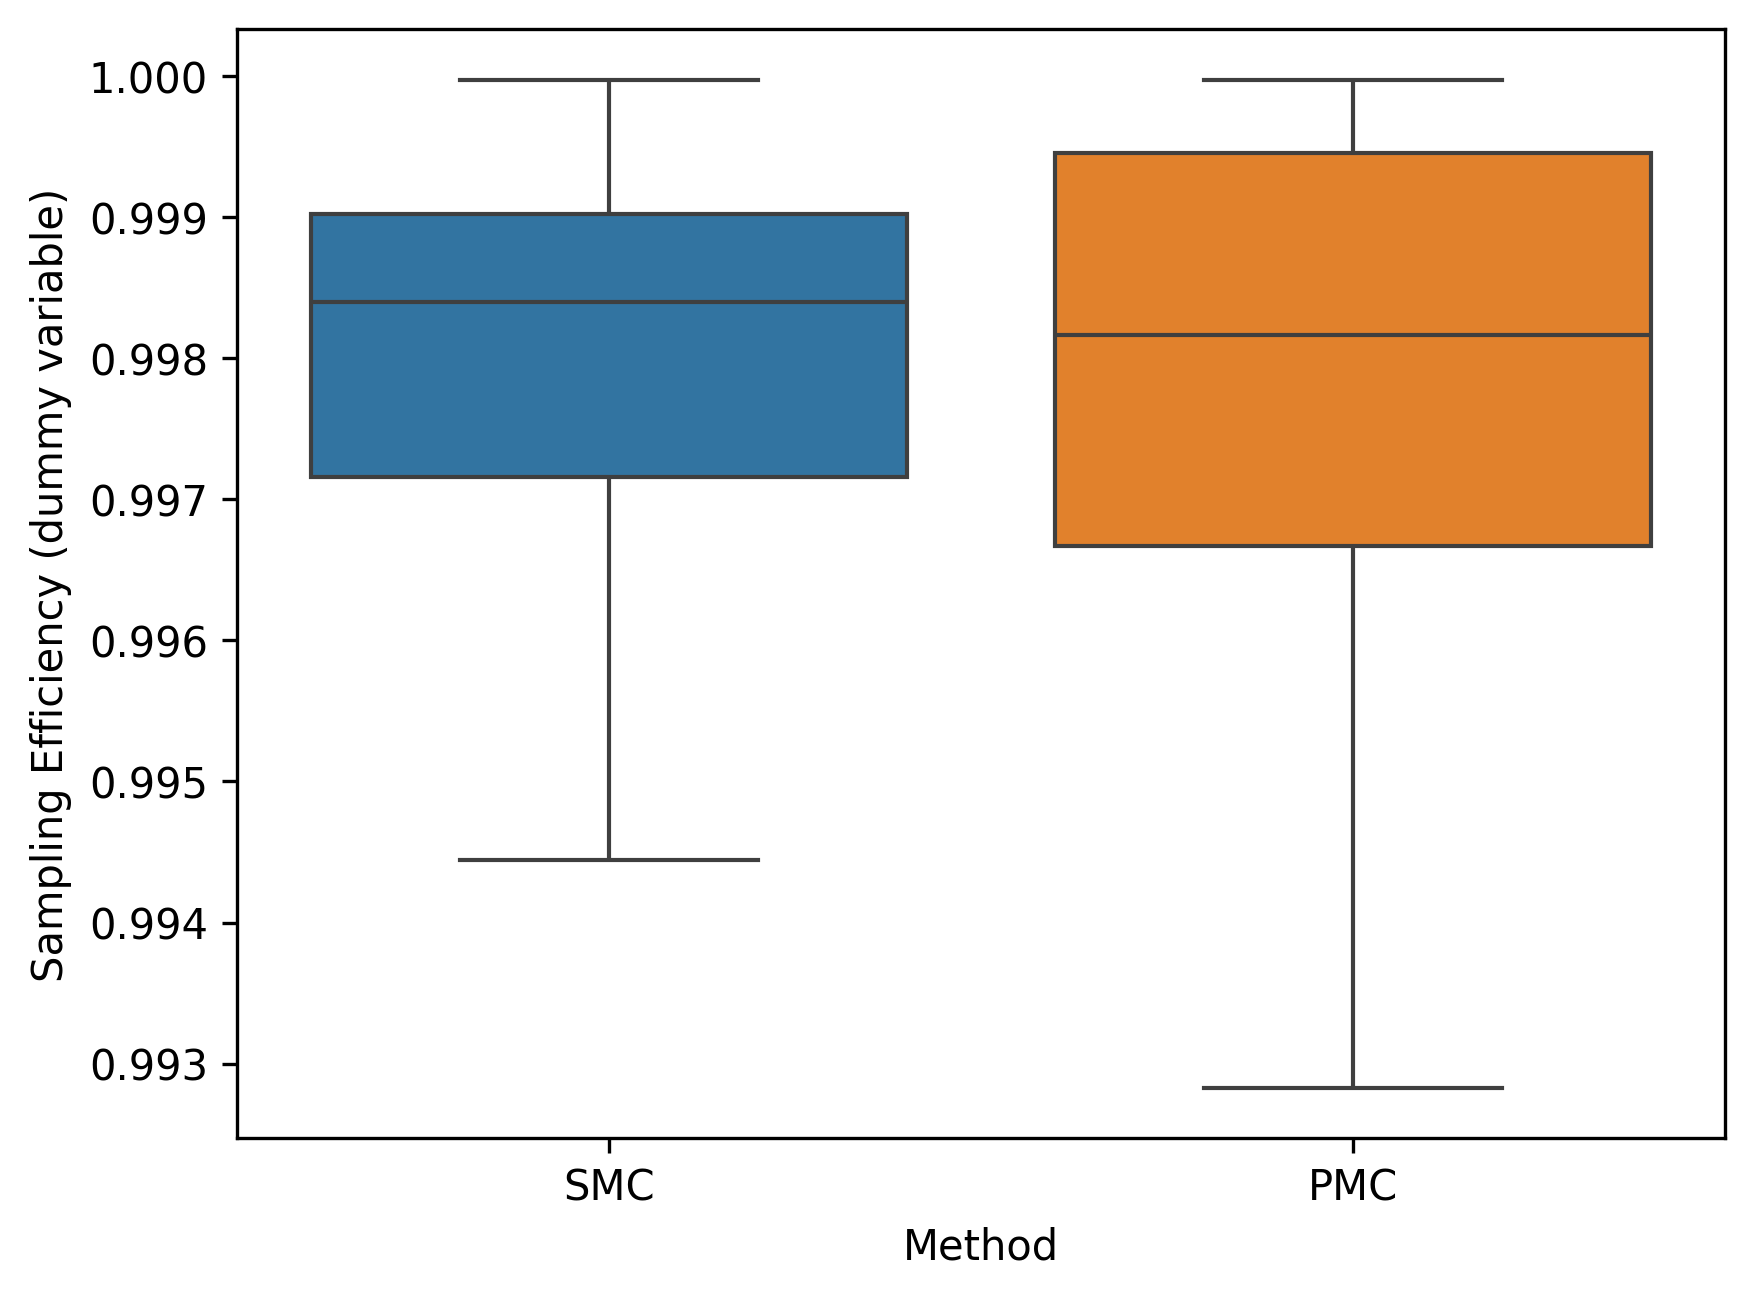

In [4]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

dummy_idx = -2

par_bounds = mod_prob.bounds
plt.figure(dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, dummy_idx) for x in grouped_results])
ratio_df = pd.DataFrame(columns=methods, data=ratios.T)

sns.boxplot(ratio_df, showfliers=False)#, size=2)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); #plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[-1]} ");
plt.ylabel("Sampling Efficiency (dummy variable)");

## Select best result for each method

In [5]:
llhs = np.array([x.get_llhs() for x in grouped_results])
best_runs = [np.argmax(np.max(x, axis=1)) for x in llhs]
best_results = [res.all_runs[best_idx] for best_idx, res in zip(best_runs, grouped_results)]

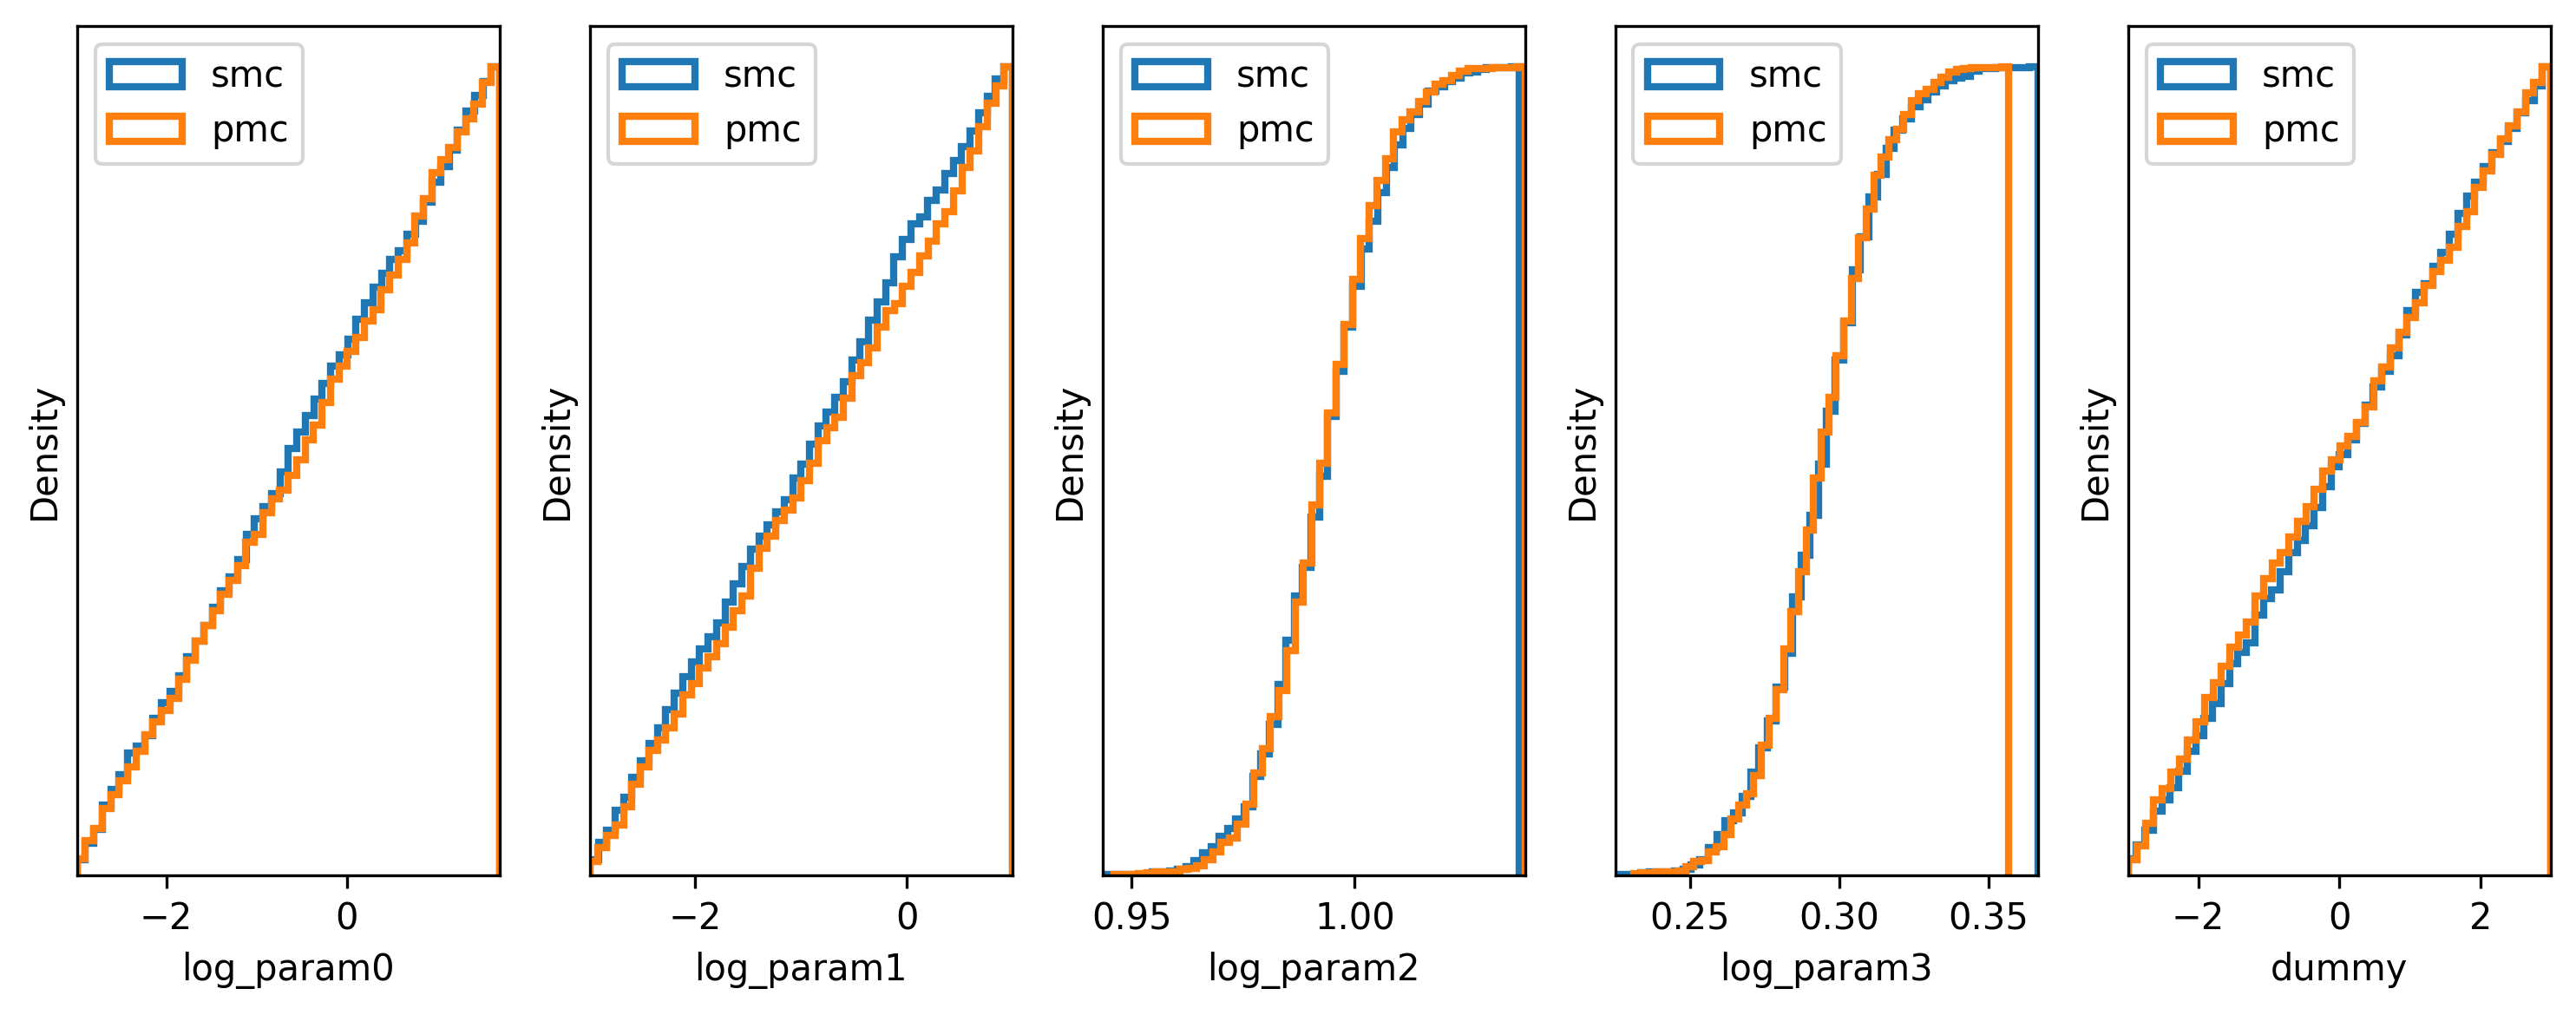

In [6]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "step"
alpha=1

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		norm_ws = cur_result.posterior_weights
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=norm_ws, color=colors[j], alpha=alpha,
			 cumulative=True, histtype="step", bins=50, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.legend()
plt.tight_layout()

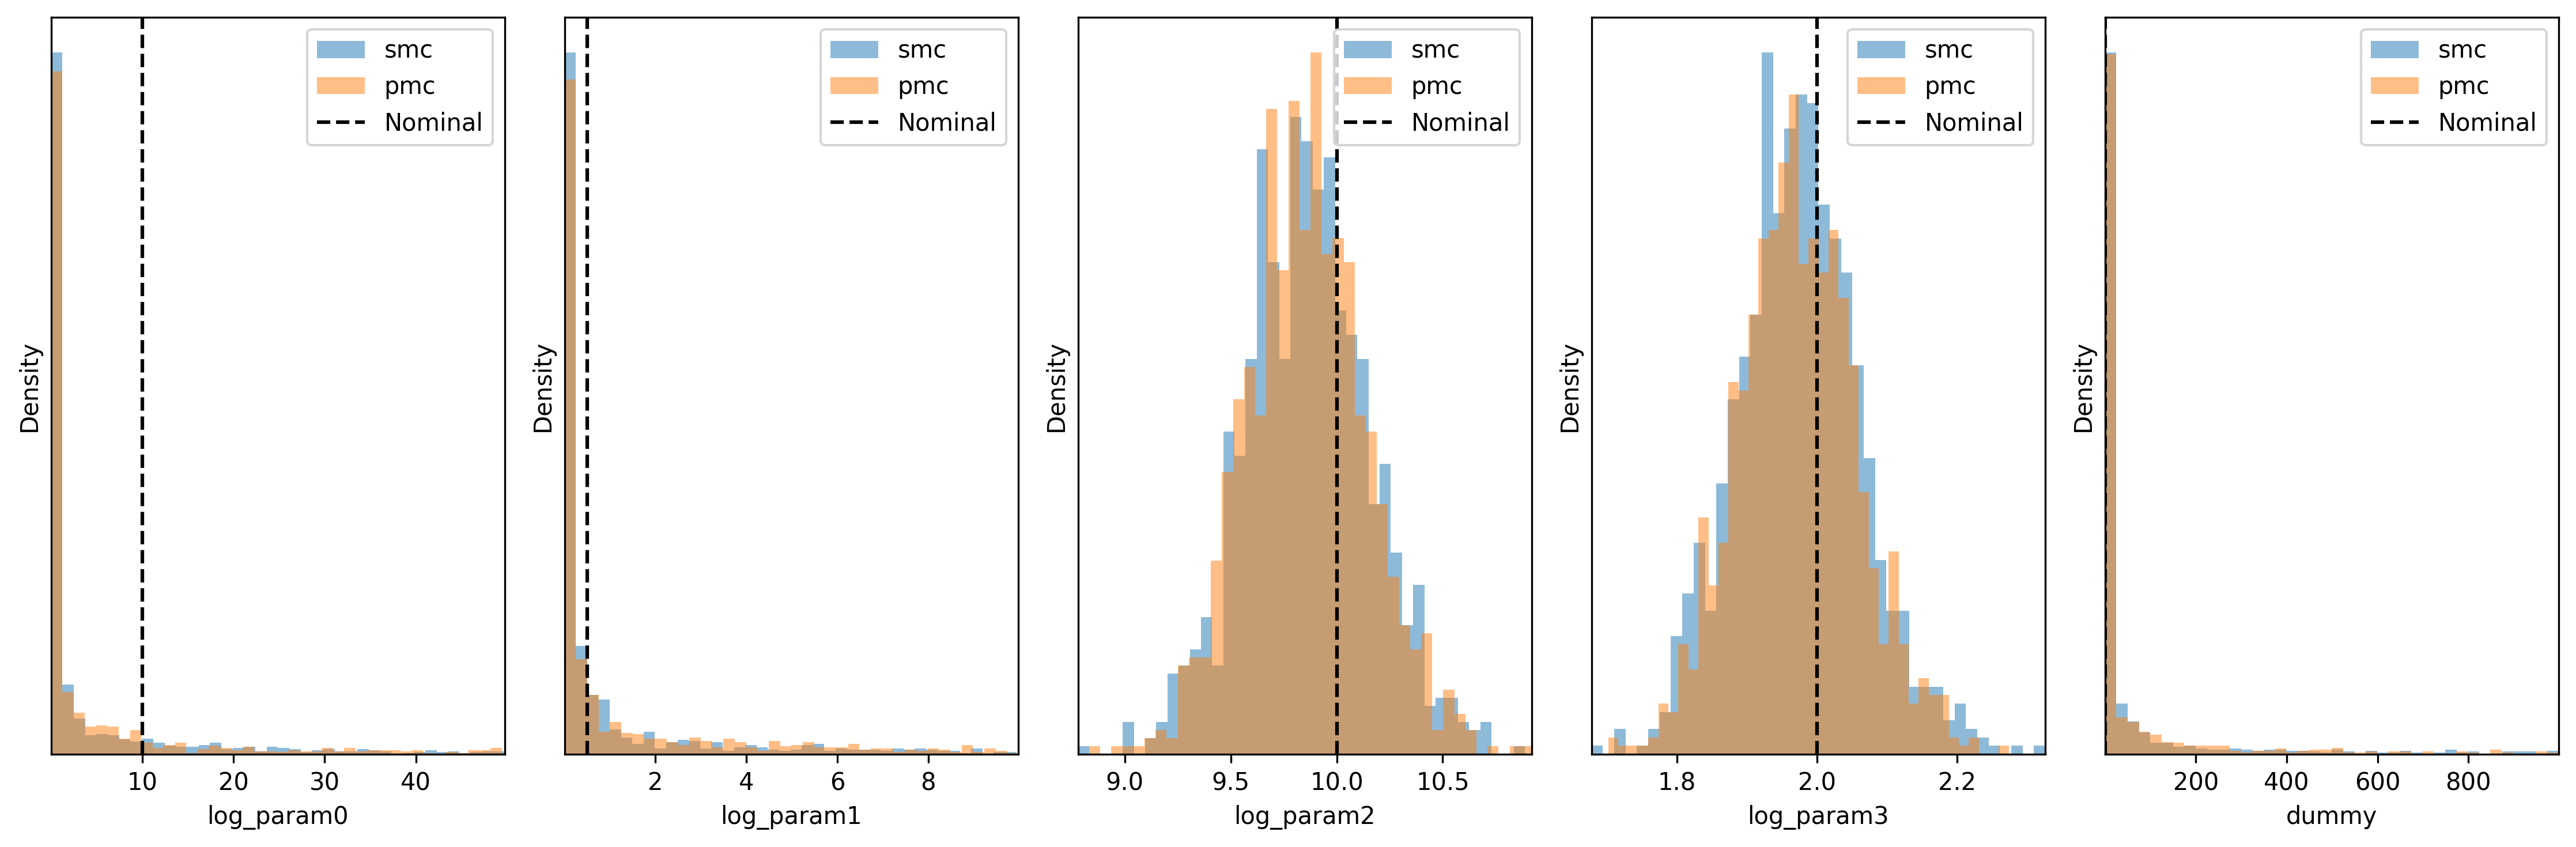

In [7]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=False)
histtype = "bar"
alpha=0.5

plt.figure(figsize=(15,5), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		plt.hist(10**cur_result.posterior_samples[:, i], lw=2, weights=cur_result.posterior_weights, color=colors[j], alpha=alpha,
			 cumulative=False, histtype=histtype, bins=40, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.axvline(x=10**xtrue[i], ls="--", color="k", label="Nominal")
	plt.legend()
plt.tight_layout()

log_param0	True:1.0	4.7558405817984655
log_param1	True:-0.3010299956639812	1.2706338449530035
log_param2	True:1.0	9.860026714483102
log_param3	True:0.3010299956639812	1.9722839323533108
dummy	True:0.0	67.39683789284176


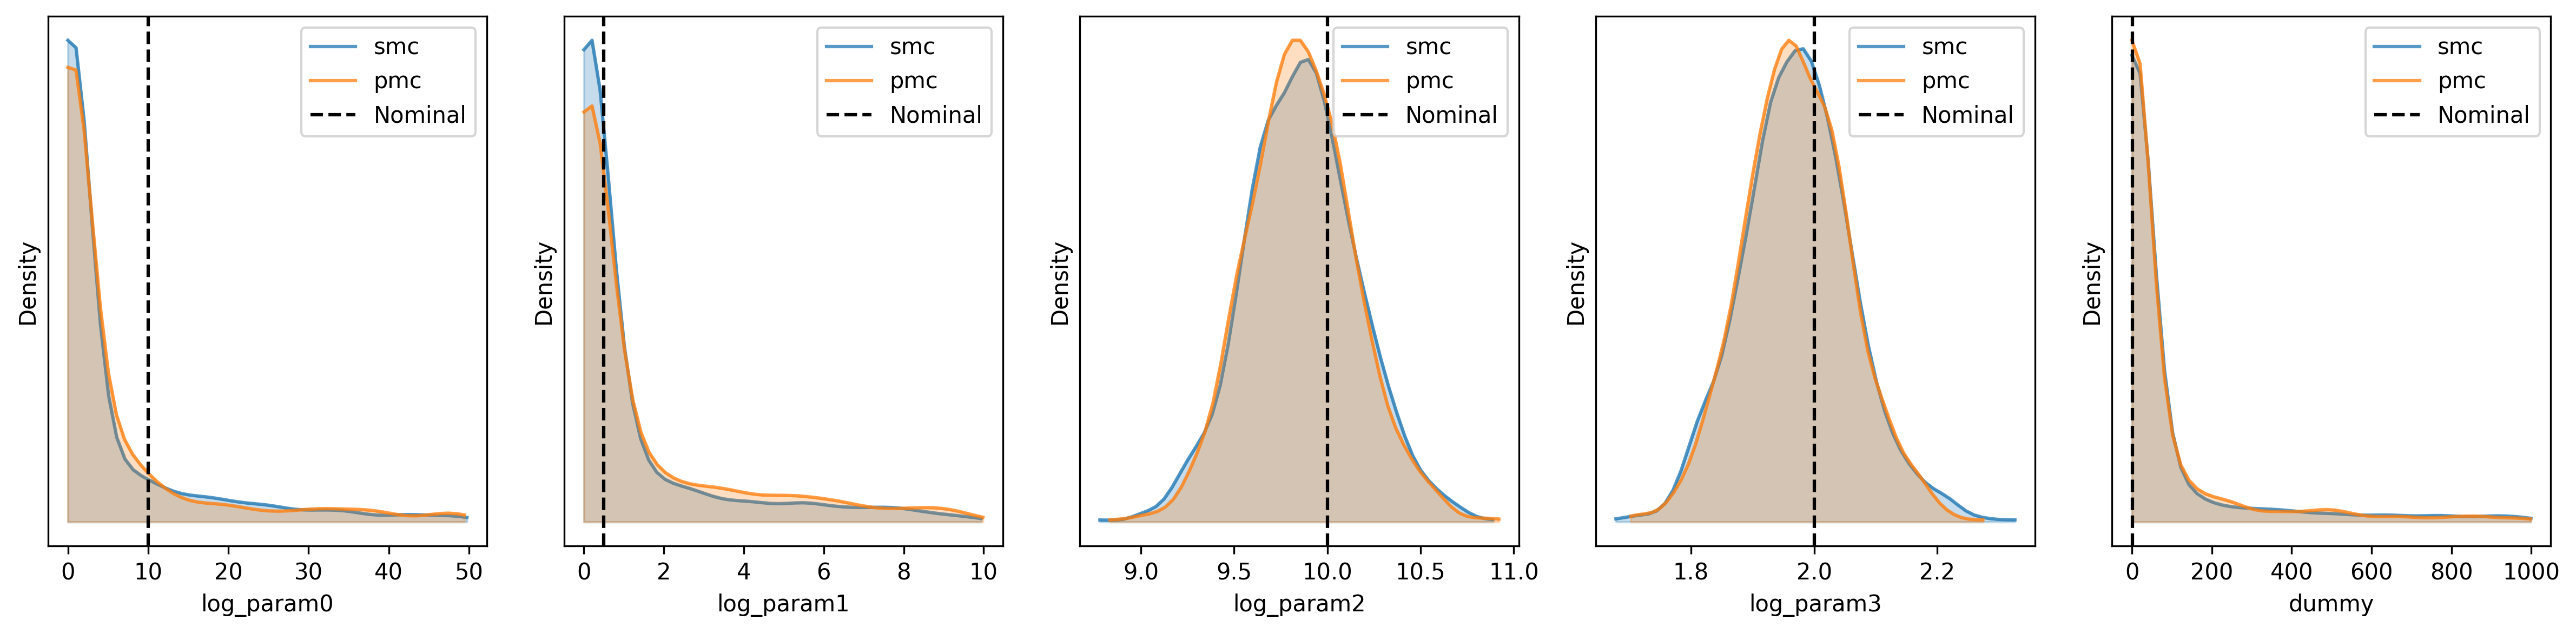

In [15]:
import scipy.stats as st
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "bar"
alpha=0.5
xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=False)
plt.figure(figsize=(16,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		param_samples = 10**cur_result.posterior_samples[:, i]
		norm_ws = cur_result.posterior_weights
		kde = st.gaussian_kde(param_samples, weights=norm_ws)
		x = np.linspace(np.min(param_samples), np.max(param_samples), 50)
		plt.plot(x, kde(x), '-', color=colors[j], alpha=0.75, zorder=1, label=cur_result.method)
		plt.fill_between(x, kde(x), alpha=0.25, color=colors[j], zorder=1)
	print(f"{par_name}\tTrue:{xtrue[i]}\t{np.average(param_samples)}")
	plt.axvline(x=10**xtrue[i], ls="--", color="k", label="Nominal")
	plt.xlabel(par_name)
	plt.yticks([])
	plt.ylabel("Density")
	#plt.margins(x=0, y=0.001)
	plt.legend()
plt.tight_layout()

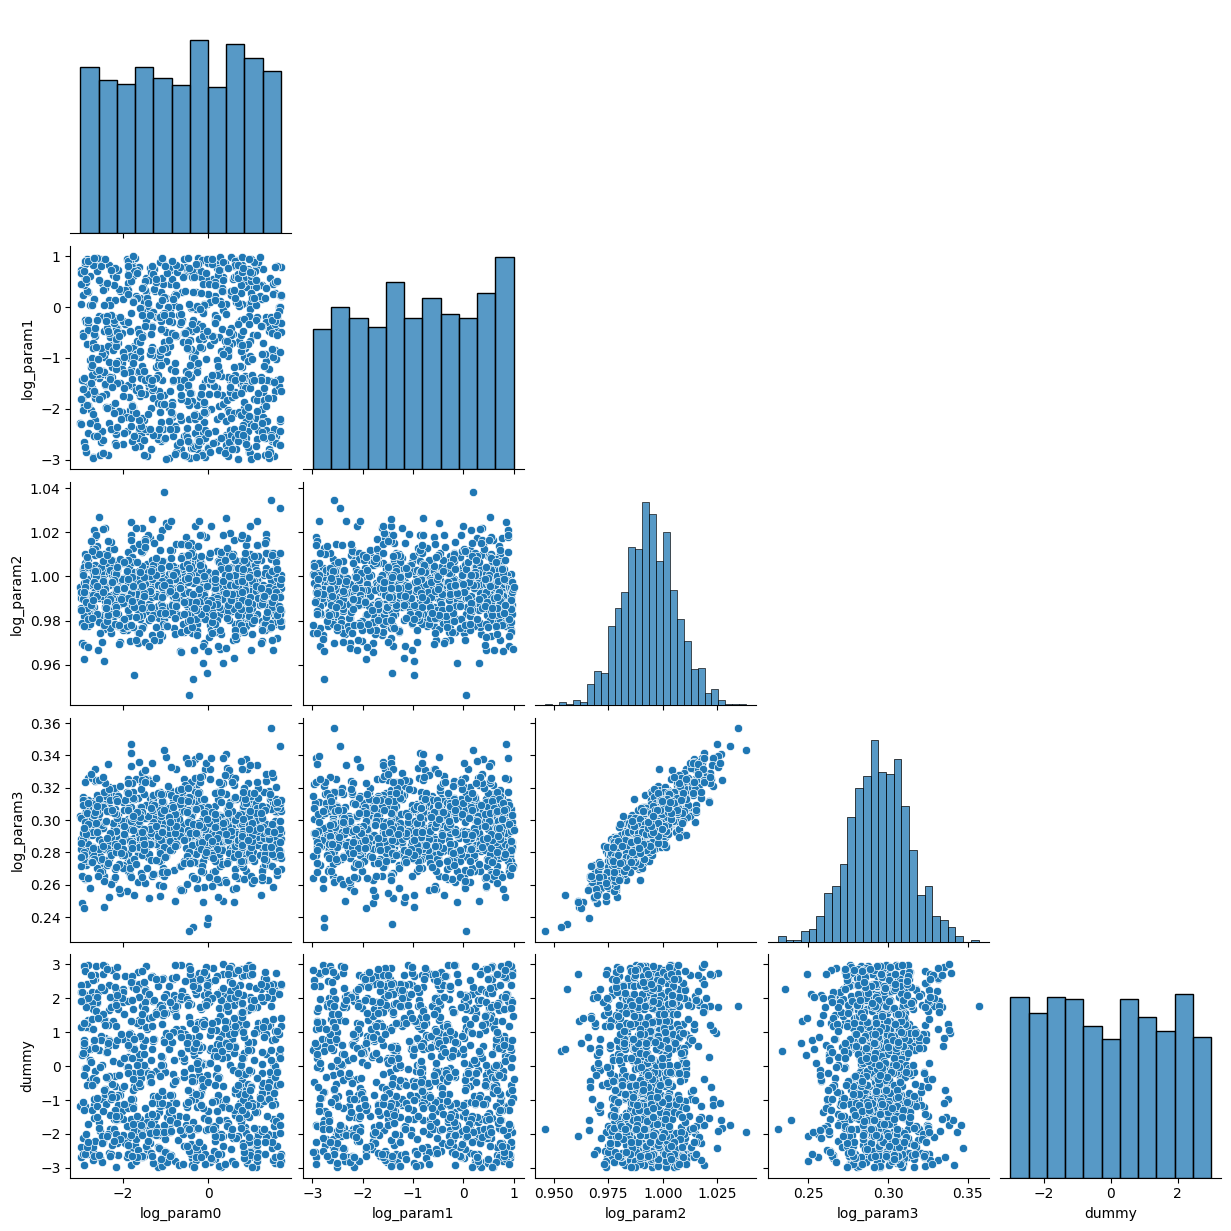

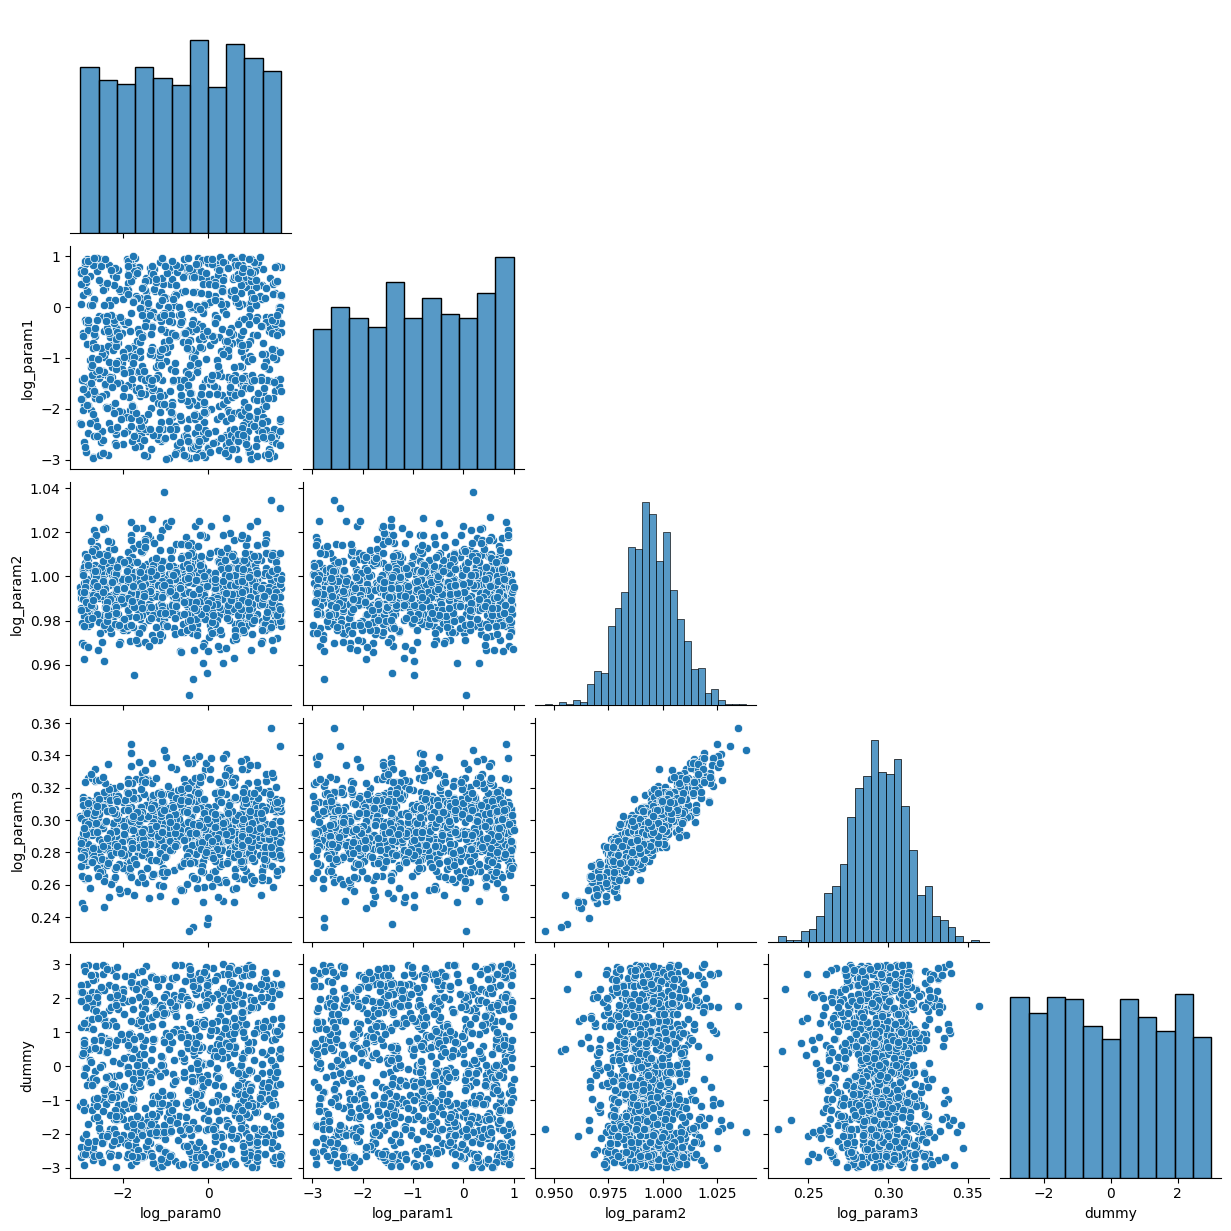

In [20]:
for i, method in enumerate(methods):
	cur_result = best_results[j]
	param_samples = cur_result.posterior_samples
	df = pd.DataFrame(data=param_samples, columns=fit_par_names)
	sns.pairplot(df, corner=True)#, color=colors[i])#, labels=fit_par_names)
	

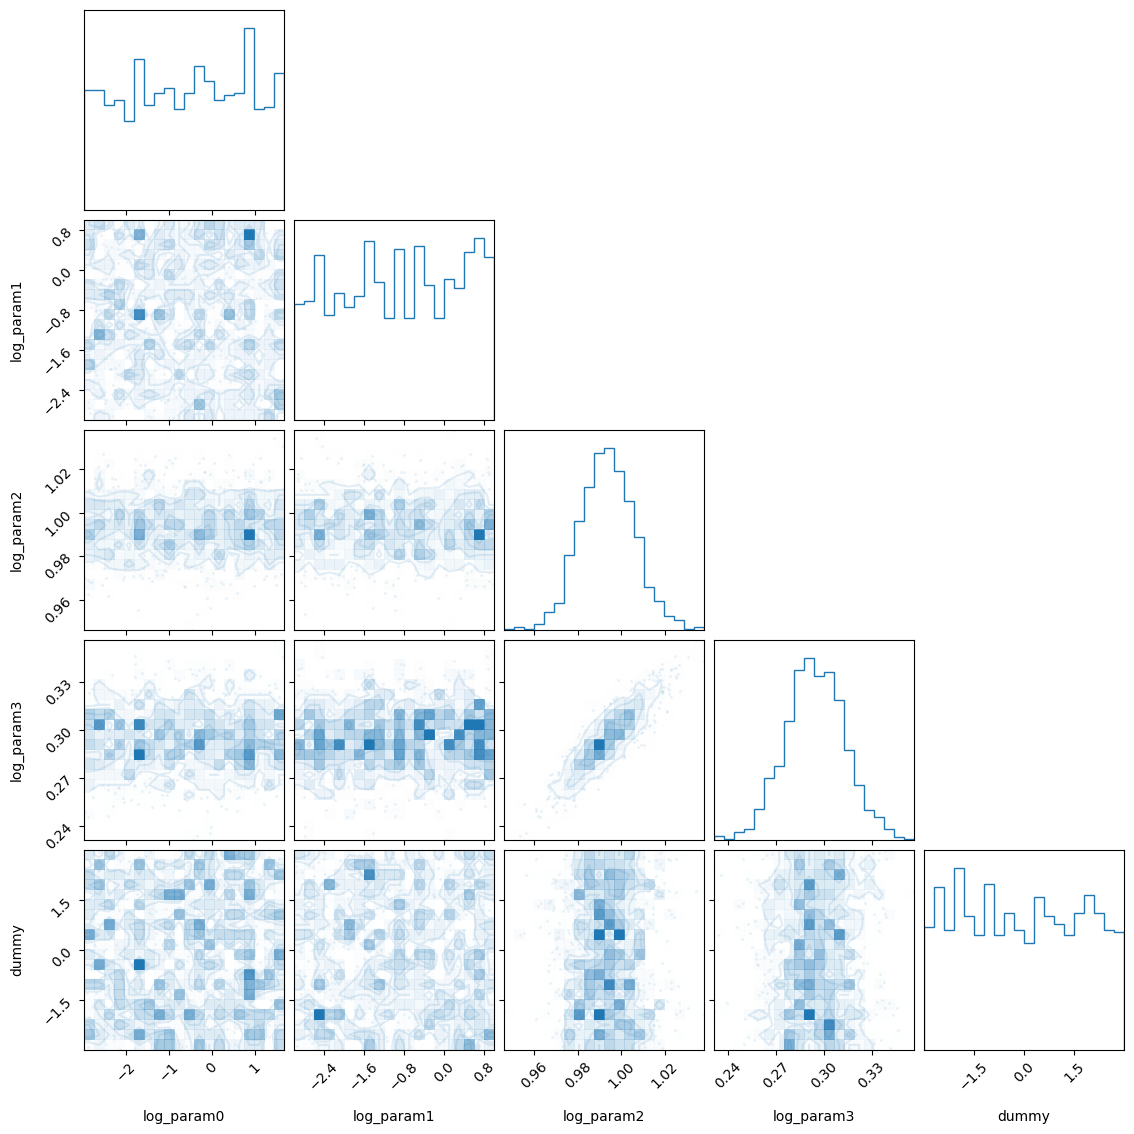

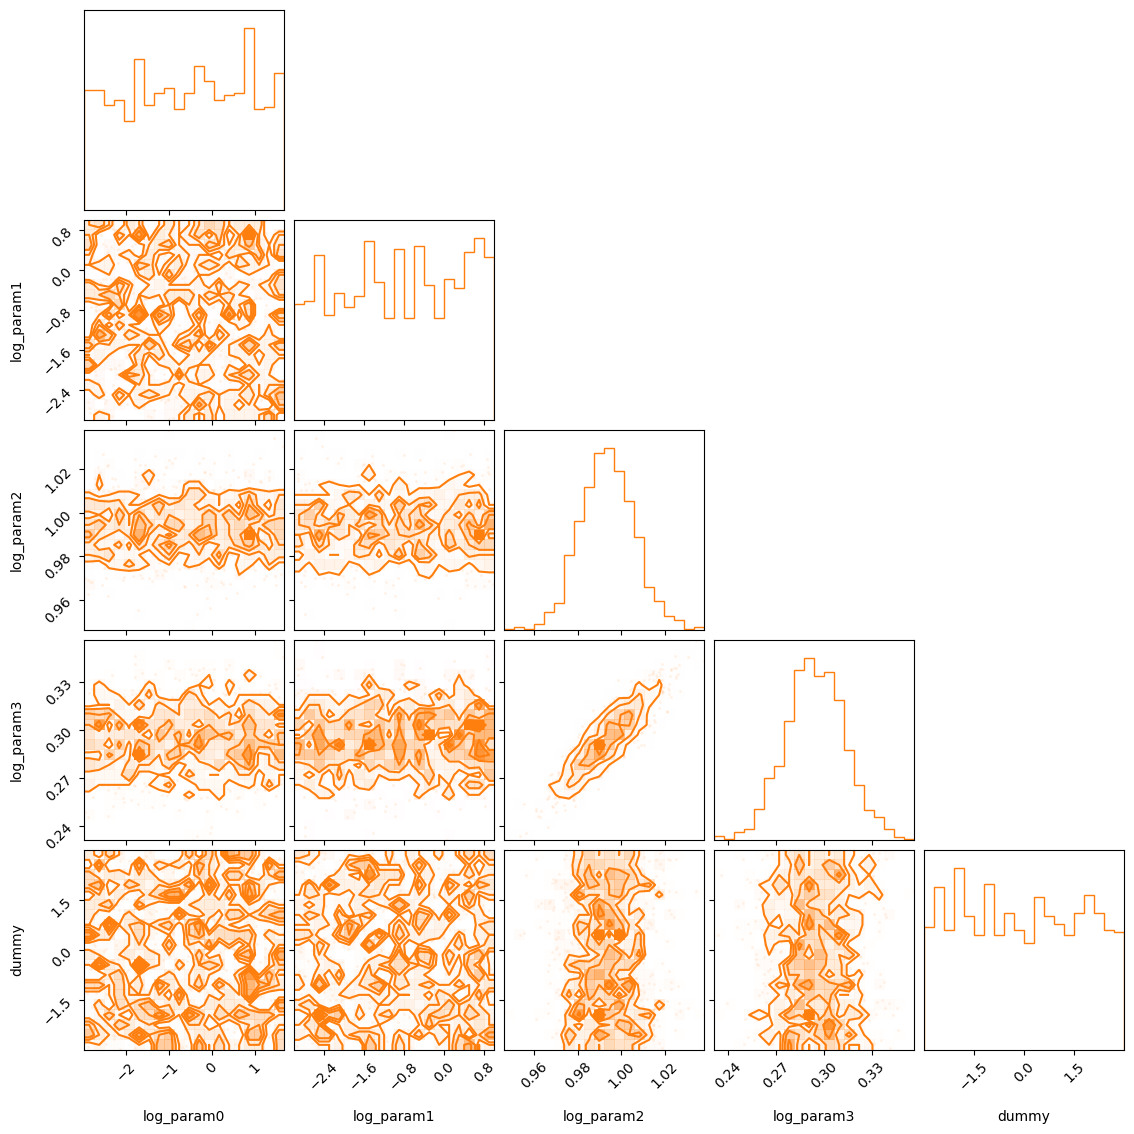

In [9]:
import corner
for i, method in enumerate(methods):
	cur_result = best_results[j]
	param_samples = cur_result.posterior_samples
	norm_ws = cur_result.posterior_weights #np.divide(cur_result.posterior_weights, np.sum(cur_result.posterior_weights))
	corner.corner(param_samples, weights=norm_ws, color=colors[i], labels=fit_par_names)
	

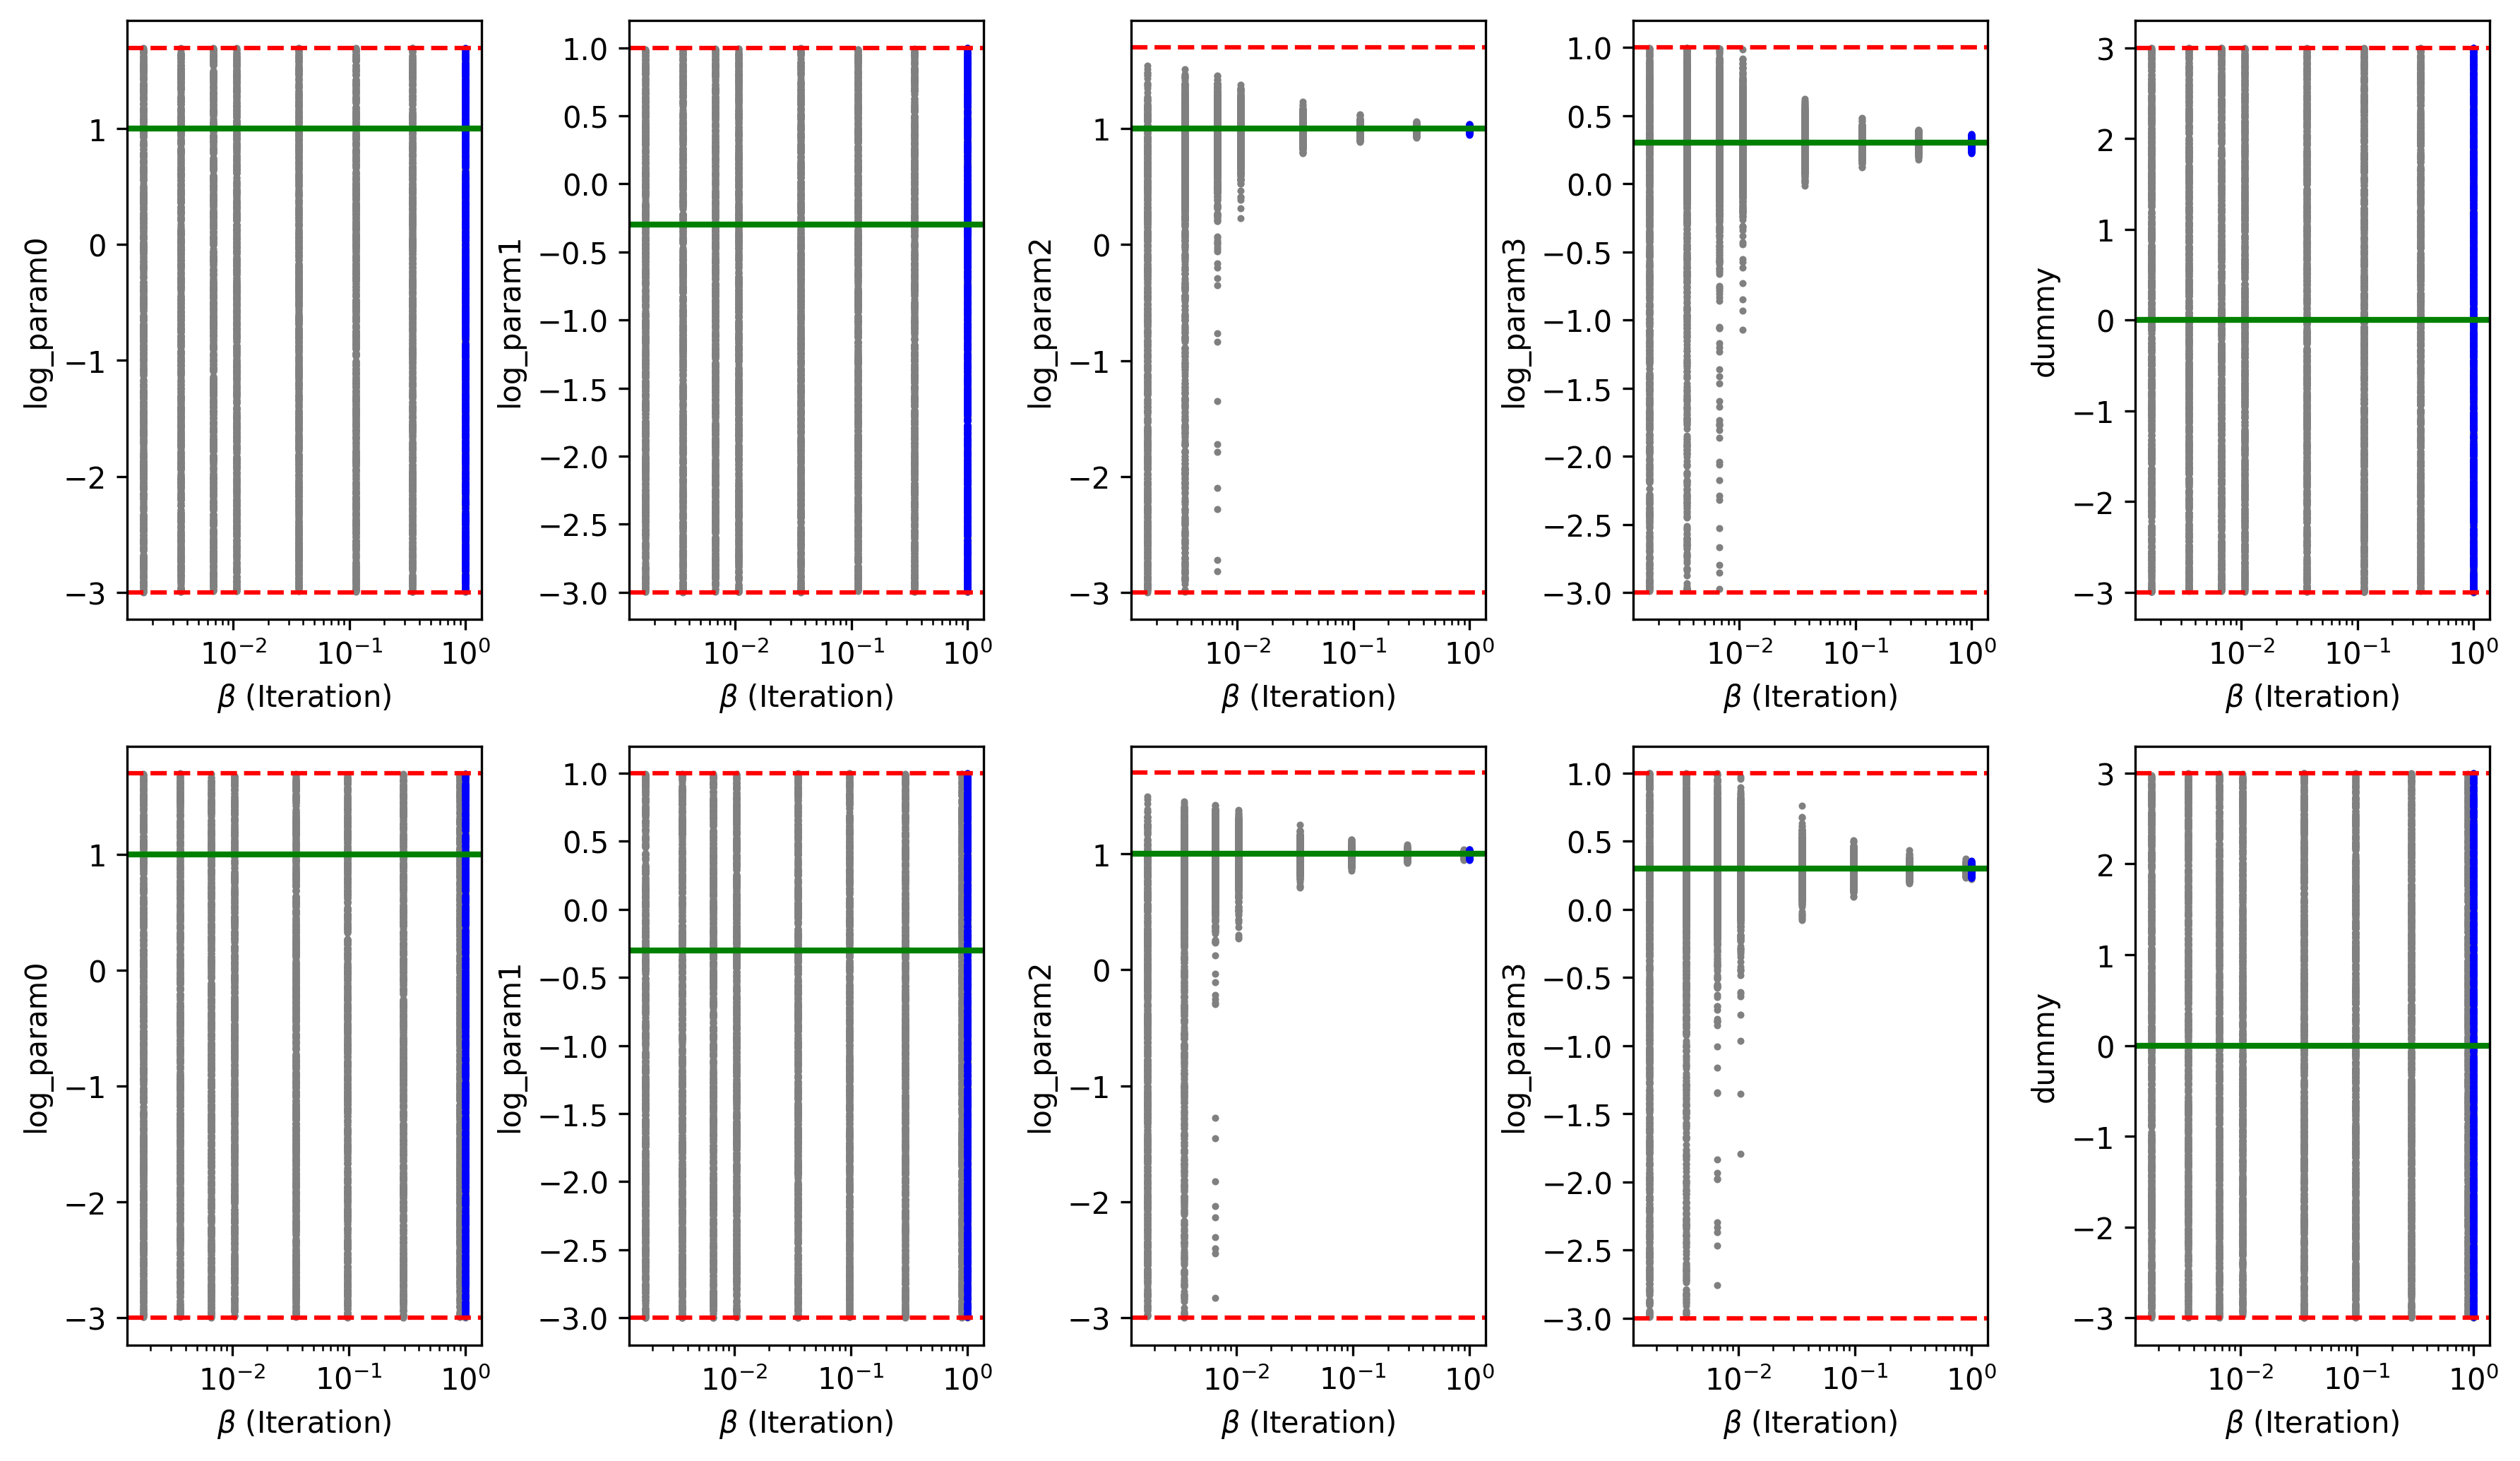

In [10]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=False)

plt.figure(figsize=(12,7), dpi=300)
fig_num = 1
for j in range(len(best_results)):
	for i, par_name in enumerate(fit_par_names):       
		cur_result = best_results[j]
		#print(f"{i}\t{cur_result.method}")
		#print(int(f"{len(best_results)}{mod_prob.n_dim}{fig_num}"))
		plt.subplot(int(len(best_results)), int(mod_prob.n_dim), fig_num)
		fig_num+=1
		n_iters = cur_result.n_iter
		n_chains = cur_result.n_chains
		n_dim = len(fit_par_names)

		cur_weights = cur_result.all_weights
		cur_trace = cur_result.all_samples[:, :, i]
		iters = cur_result.iters


		# Left column -- beta plots
		for q, it in enumerate(iters):
			if cur_result.method == "ptmcmc":
				if q % 100 != 0:
					continue
			color='grey'
			if q == n_iters - 1:
				color='blue'
			plt.scatter(
				np.full(n_chains, it),
				cur_trace[q, :],
				s=2,
				c=color,
				#alpha=cur_weights[q, :]
			)
	
		# Plot bounds
		plt.axhline(y=par_bounds[i][0], color='r', linestyle='--')
		plt.axhline(y=par_bounds[i][1], color='r', linestyle='--')
		plt.axhline(y=xtrue[i], color="g", lw=2)
		plt.ylabel(par_name)
		if cur_result.method != "ptmcmc":
			plt.xscale('log')
			plt.xlabel(r'$\beta$ (Iteration)')
		else:
			plt.xlabel("Iteration Number")
plt.tight_layout()

In [11]:
from pypesto.objective import AggregatedObjective
from pypesto.objective.roadrunner.road_runner import RoadRunnerObjective
obj = mod_prob.problem.objective
og_obj = obj
if isinstance(obj, AggregatedObjective):
    subobjs = mod_prob.problem.objective.__dict__["_objectives"]
    for subobj in subobjs:
        if isinstance(subobj, RoadRunnerObjective):
            obj = subobj
        else:
            continue

## Plot fits to model data

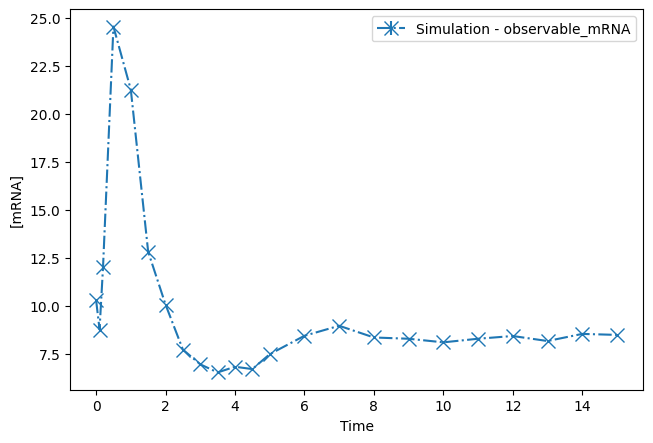

In [12]:
CI = 0.95
UPPER_PCT = (1 - (1-CI)/2)
LOWER_PCT = ((1-CI)/2)

petab_prob = mod_prob.petab_problem
ax_dict = plot_problem(petab_problem=petab_prob,) 
fig = plt.gcf()
# Change the figure size
fig.set_size_inches(6,4)

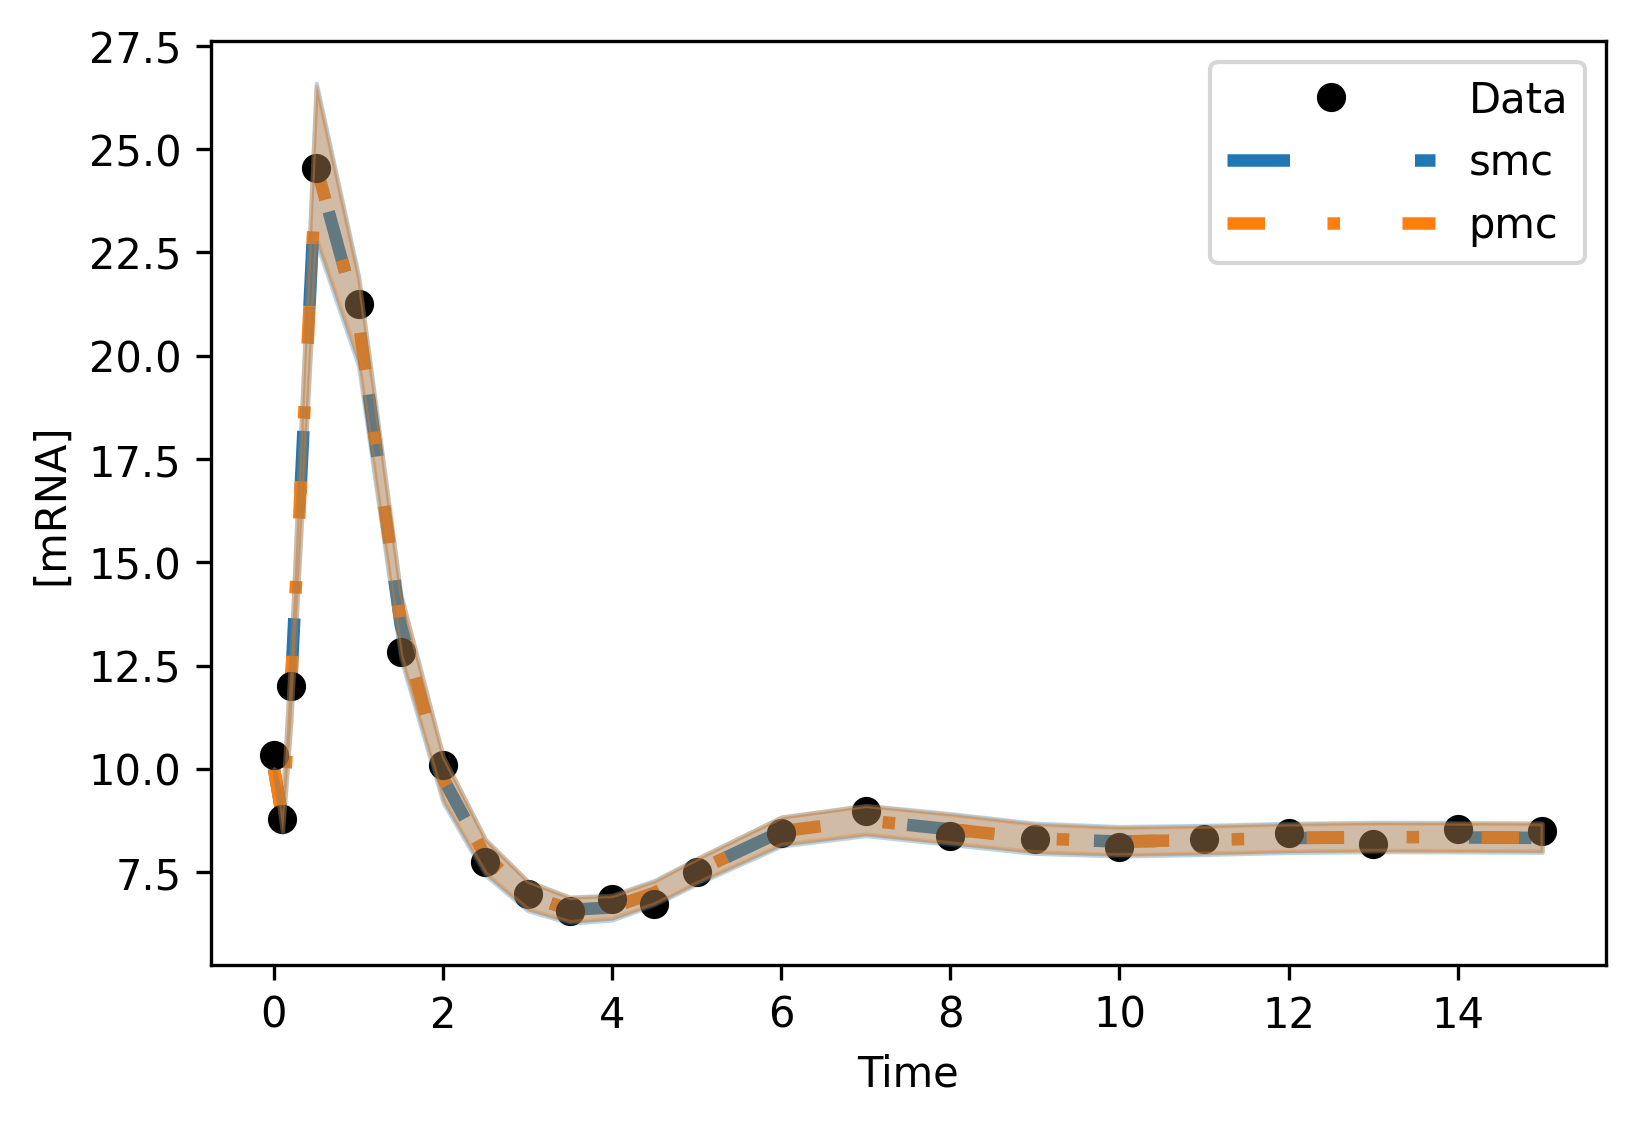

In [13]:
measure_df = petab_prob.measurement_df
plt.figure(figsize=(6,4), dpi=300)
plt.plot(measure_df["time"], measure_df["measurement"], "ko", label="Data", zorder=2)
lss = [(0,(5,10)), (0,(3,5,1,5)), (0,(1,4))]
for i, best in enumerate(best_results):
	pars = best.posterior_samples
	weights = best.posterior_weights

	all_sim_data = np.empty(shape=(measure_df.shape[0], pars.shape[0]))

	## Collect all of the runs simulation information
	for n, par in enumerate(pars):
		sim = obj(par, mode="mode_fun", return_dict=True)["simulation_results"]["simCondition"]
		all_sim_data[:, n] = sim[:, 1]
		sim_ts = sim[:, 0]
		
	n_ts = len(sim_ts)
	mean_sim_data = np.average(all_sim_data, weights=weights, axis=1)
	temp = np.array([weighted_quantile(x, [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])
	#print(temp[0])
	low_sim_data = temp[:, 0]
	high_sim_data = temp[:, 1]

	plt.plot(sim_ts, mean_sim_data, lw=3, linestyle=lss[i], label=best.method, zorder=1, color=colors[i])
	plt.fill_between(sim_ts, low_sim_data, high_sim_data, zorder=3, alpha=0.3, color=colors[i])
plt.legend(handlelength=5)
plt.xlabel("Time"); plt.ylabel("[mRNA]");

['S1', 'S2', 'S3']


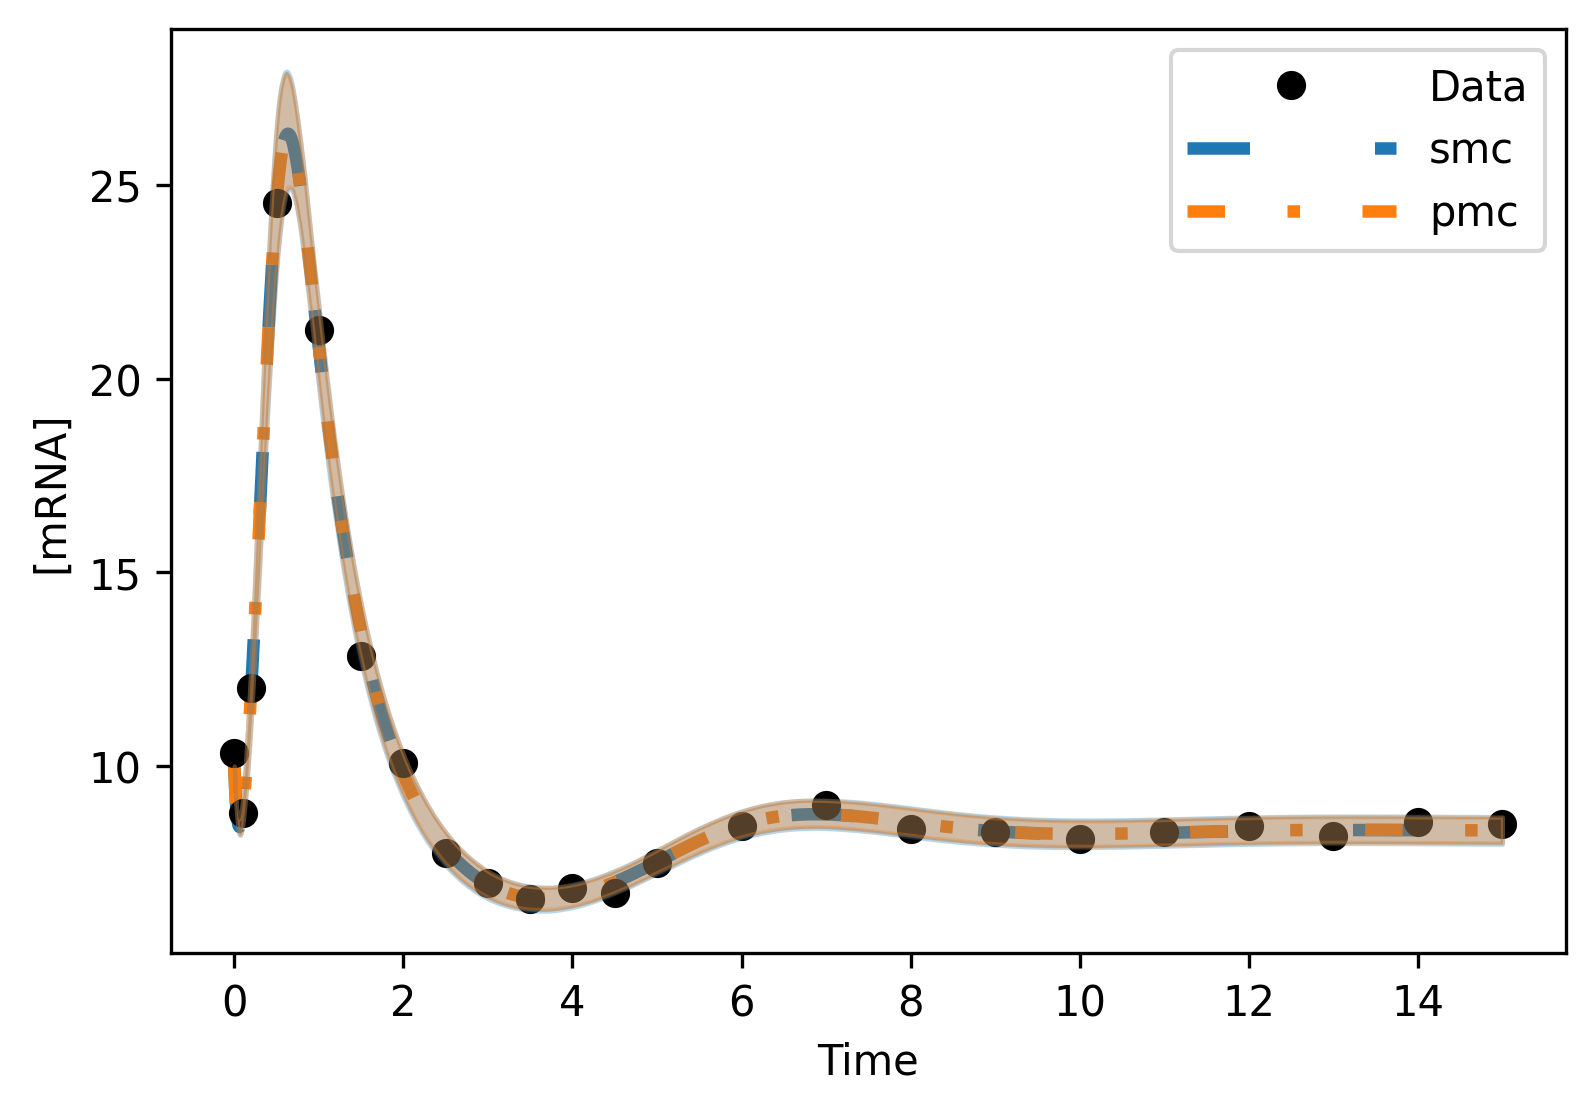

In [14]:
measure_df = petab_prob.measurement_df
plt.figure(figsize=(6,4), dpi=300)
plt.plot(measure_df["time"], measure_df["measurement"], "ko", label="Data", zorder=2)

max_t = np.max(measure_df["time"])
n_sim_ts = int(max_t*100 + 1)
simu = obj.roadrunner_instance
print(simu.model.getFloatingSpeciesIds())

lss = [(0,(5,10)), (0,(3,5,1,5)), (0,(1,4))]
for i, best in enumerate(best_results):
	pars = best.posterior_samples
	weights = best.posterior_weights

	all_sim_data = np.empty(shape=(n_sim_ts, pars.shape[0]))

	## Collect all of the runs simulation information
	for n, par in enumerate(pars):
		#sim = obj(par, mode="mode_fun", return_dict=True)["simulation_results"]["simCondition"]
		simu.resetAll()
		for name, x in zip(fit_par_names, par):
			simu[name] = x
		simu.reset()
		sim = simu.simulate(0, max_t, n_sim_ts)
		all_sim_data[:, n] = sim[:, 1]
		sim_ts = sim[:, 0]
	n_ts = len(sim_ts)
	mean_sim_data = np.average(all_sim_data, weights=weights, axis=1)
	temp = np.array([weighted_quantile(x, [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])
	#print(temp[0])
	low_sim_data = temp[:, 0]
	high_sim_data = temp[:, 1]
	
	plt.plot(sim_ts, mean_sim_data, lw=3, linestyle=lss[i], label=best.method, zorder=1, color=colors[i])
	plt.fill_between(sim_ts, low_sim_data, high_sim_data, zorder=3, alpha=0.3, color=colors[i])
plt.legend(handlelength=5)
plt.xlabel("Time"); plt.ylabel("[mRNA]");